# SIR Model for Viral Marketing

In [1]:
from decimal import Decimal
import pandas as pd
import numpy as np
from datetime import timedelta

%matplotlib inline
import pandas as pd
from tabulate import tabulate

from SimCAD.configuration import Configuration
from SimCAD.configuration.utils import exo_update_per_ts, proc_trigger, bound_norm_random, \
    ep_time_step

In [2]:
sim_config = {
    'N': 1,
    'T': range(50)
}

seed = {}
env_processes = {}
initial_condition = {
    'Budget': float(50),
    'S': float(1000),
    'I': float(10),
    'R': float(0),
    'beta': float(0.05), # contact rate between S and I
    'gamma': float(0.2), # recover rate from I to R
    'timestamp': '2019-01-01 00:00:00'
}

# Parameters
epsilon = 0.03
subscription_fee = 1
incentive_cost = 10
stickiness_cost = 5
delta_beta = 0.1
delta_gamma = 0.1

ts_format = '%Y-%m-%d %H:%M:%S'
t_delta = timedelta(days=0, minutes=0, seconds=1)
def time_model(step, sL, s, _input):
    y = 'timestamp'
    x = ep_time_step(s, dt_str=s['timestamp'], fromat_str=ts_format, _timedelta=t_delta)
    return (y, x)

exogenous_states = exo_update_per_ts(
    {
    'timestamp': time_model
    }
)

In [3]:
# Behaviors choose actions depending on states
# 1) increase contact rate, beta (create incentive to spread)
# 2) decrease recover rate, gamma (improve stickiness)

def add_incentive(step, sL, s):
    delta = 0.0
    potential_delta = s['beta'] * delta_beta
    if (s['S'] > 3 * s['I']) and s['Budget'] > \
        abs(potential_delta * incentive_cost * s['S']):
        delta = potential_delta
    return {'delta': delta}

def add_stickiness(step, sL, s):
    delta = 0.0
    potential_delta = s['gamma'] * delta_gamma
    if (s['R'] > 2 * s['I']) and s['Budget'] > \
        abs(potential_delta * stickiness_cost * s['I']):
        delta = potential_delta
    return {'delta': delta}

def dummy_behavior(step, sL, s):
    return {'delta': 0.0}

# Mechanisms incur cost to modify beta or gamma
# 1) incur cost to create incentive to spread
# 2) incur cost to improve stickiness

def incur_incentive_cost(step, sL, s, _input):
    y = 'Budget'
    x = s['Budget'] - abs(_input['delta'] * s['S'] * incentive_cost)
    return (y, x)

def incur_stickiness_cost(step, sL, s, _input):
    y = 'Budget'
    x = s['Budget'] - abs(_input['delta'] * s['I'] * stickiness_cost)
    return (y, x)

def update_beta(step, sL, s, _input):
    y = 'beta'
    x = s['beta'] + _input['delta']
    return (y, x)

def update_gamma(step, sL, s, _input):
    y = 'gamma'
    x = s['gamma'] - _input['delta']
    return (y, x)

def S_model(step, sL, s, _input):
    y = 'S'
    x = s['S'] - s['beta'] * s['S']
    return (y, x)

def I_model(step, sL, s, _input):
    y = 'I'
    x = s['I'] + s['beta'] * s['S'] - s['gamma'] * s['I']
    return (y, x)
    
def R_model(step, sL, s, _input):
    y = 'R'
    x = s['R'] + s['gamma'] * s['I']
    return (y, x)

def collect_subscription(step, sL, s, _input):
    y = 'Budget'
    x = s['Budget'] + s['I'] * epsilon * subscription_fee
    return (y, x)

mechanisms = {
    'spread': {
        'behaviors': {
            'dummy': dummy_behavior
        },
        'states': {
            'S': S_model,
            'I': I_model,
            'R': R_model,
            'Budget': collect_subscription
        }      
    },
    'create_incentive': {
        'behaviors': {
            'action': add_incentive,
        },
        'states': {
            'beta': update_beta,
            'Budget': incur_incentive_cost,
        }
    },
    'improve_stickiness': {
        'behaviors': {
            'action': add_stickiness
        },
        'states': {
            'gamma': update_gamma,
            'Budget': incur_stickiness_cost,
        }
    }
}

In [4]:
config = Configuration(
            sim_config=sim_config,
            state_dict=initial_condition,
            seed=seed,
            exogenous_states=exogenous_states,
            env_processes=env_processes,
            mechanisms=mechanisms)

from SimCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.main()

single_proc: [<SimCAD.configuration.Configuration object at 0x11768bf98>]


In [5]:
df = pd.DataFrame(raw_result)

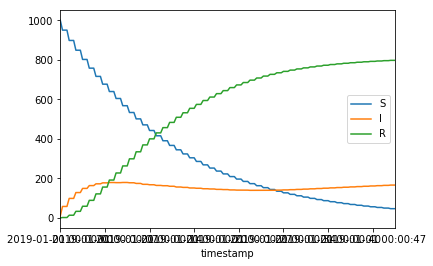

In [6]:
df.plot('timestamp', ['S','I', 'R'])

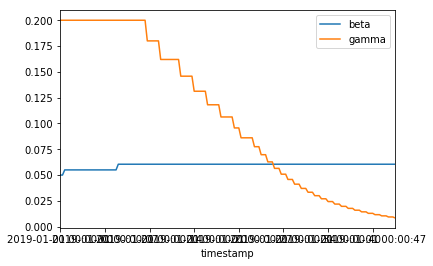

In [7]:
df.plot('timestamp', ['beta', 'gamma'])

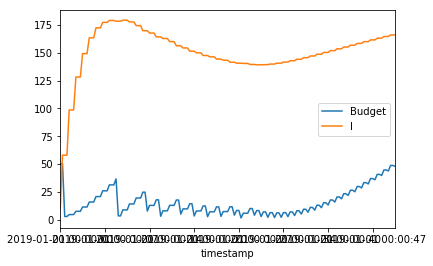

In [8]:
df.plot('timestamp', ['Budget', 'I'])

In [9]:
df[['S','I', 'R']].describe()

,S,I,R
count,151.000000,151.000000,151.000000
mean,315.519268,150.861455,543.619277
std,262.343126,23.127729,258.137254
min,46.767724,10.000000,0.000000
25%,98.897388,142.907707,369.363864
50%,222.600751,151.473138,644.034432
75%,470.722775,163.532271,763.921377
max,1000.000000,179.316172,797.102843
